In [1]:
from objects import *
import numpy as np
import matplotlib.pyplot as plt
import copy

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
from matplotlib import pyplot as plt


# suppress sklearn warnings
def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, ExpSineSquared

In [2]:
from objects import *
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [3]:
# return to default and make the fontbigger
plt.rcParams.update(plt.rcParamsDefault)
font = {'size'   : 15}
plt.rc('font', **font)

# AIMD example

In [16]:
def parse_qe_pwscf_md_output(outfile):
#def parse_qe_pwscf_md_output(path):

    steps={}

    # Get the lines out of the file first
    with open(outfile, 'r') as outf:
        lines = outf.readlines()

    # Because every step is marked by a total energy printing with the !
    # as the first character of the line, partition the file of output
    # into all different chunks of run data

    # Get the indexes to carve up the document later
    split_indexes=[N for N in range(len(lines)) if '!'==lines[N][0]]

    # Cut out the first chunk 
    # TODO: Analyze first chunk
    first_chunk=lines[0:split_indexes[0]]

    step_chunks = []
    # Carve up into chunks
    for n in range(len(split_indexes)):
        step_chunks.append(lines[split_indexes[n]:split_indexes[n+1] if n!=len(split_indexes)-1 else len(lines)]) 



    # Iterate through chunks
    for current_chunk in step_chunks:


        # Iterate through to find the bounds of regions of interest

        # Forces
        force_start_line = [line for line in current_chunk if 'Forces acting on atoms' in line][0]
        force_end_line   = [line for line in current_chunk if 'Total force' in line][0]
        force_start_index = current_chunk.index(force_start_line)+2
        force_end_index = current_chunk.index(force_end_line)-2

        # Positions
        atoms_start_line = [line for line in current_chunk if 'ATOMIC_POSITIONS' in line][0]
        atoms_end_line   = [line for line in current_chunk if 'kinetic energy' in line][0]
        atoms_start_index = current_chunk.index(atoms_start_line)+1
        atoms_end_index = current_chunk.index(atoms_end_line)-3

        # Misc Facts
        temperature_line = [ line for line in current_chunk if 'temperature' in line][0]
        dyn_line = [line for line in current_chunk if 'Entering Dynamics' in line][0]
        dyn_index = current_chunk.index(dyn_line)
        time_index = dyn_index+1

        # Parse through said regions of interest to get the information out

        forces = []
        for line in current_chunk[force_start_index:force_end_index+1]:
            forceline= line.split('=')[-1].split()
            forces.append([float(forceline[0]),float(forceline[1]),float(forceline[2])])
        total_force = float(force_end_line.split('=')[1].strip().split()[0])
        SCF_corr    = float(force_end_line.split('=')[2].strip()[0])


        positions =[]
        elements=[]
        for line in current_chunk[atoms_start_index:atoms_end_index+1]:
            atomline = line.split()
            elements.append(atomline[0])
            positions.append([float(atomline[1]),float(atomline[2]),float(atomline[3])])

        # Get Misc info 
        toten = float(current_chunk[0].split('=')[-1].strip().split()[0])
        temperature_line = temperature_line.split('=')[-1]
        temperature = float(temperature_line.split()[0])
        iteration = int(dyn_line.split('=')[-1])
        timeline = current_chunk[time_index].split('=')[-1].strip().split()[0]
        time = float( timeline)
        Ekin = float(atoms_end_line.split('=')[1].strip().split()[0])


        # Record the data associated with this step
        steps[iteration]={'iteration':iteration,
                           'forces':forces, 
                           'positions':positions,
                           'elements':elements,
                           'temperature':temperature,
                           'time':time,
                           'energy':toten,
                           'ekin':Ekin,
                           'kinetic energy':Ekin,
                           'total energy':toten,
                           'total force':total_force,
                           'SCF correction':SCF_corr}

    return(steps)

In [17]:
outfile ='/Users/jonpvandermause/Research/GP/ML-electron-density/Si_Supercell_MD/si.md.out'
Si_MD_Parsed = parse_qe_pwscf_md_output(outfile)

In [18]:
tstep = 20 * 4.83776865301828e-17

In [19]:
ens = []
times = [tstep * n for n in range(1000)]
for n in range(1000):   
    en = Si_MD_Parsed[n+1]['energy']
    
    ens.append(en)

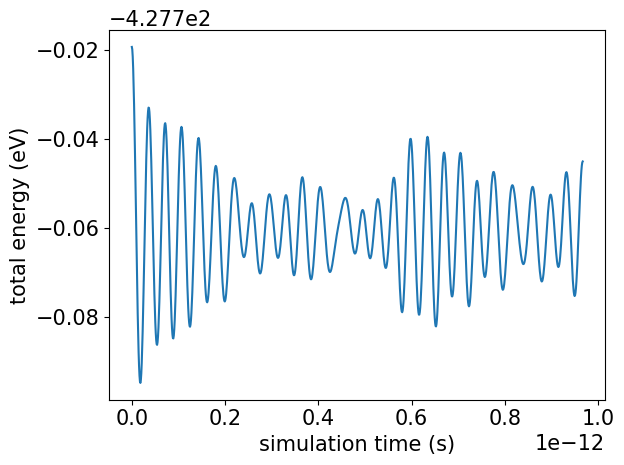

In [21]:
f = plt.figure()
plt.plot(times, ens)
plt.xlabel('simulation time (s)')
plt.ylabel('total energy (eV)')
plt.show()

f.savefig('test.pdf', format='pdf',bbox_inches='tight')

# GP toy figure

In [22]:
ens = []
seps = []

# path to data
os.environ['PROJDIR'] = '/Users/jonpvandermause/Desktop'
STR_PREF = os.environ['PROJDIR'] + '/store/'
sim_no = 150
m = 7

for n in range(sim_no):
    # load separation, energy, and density
    sep = np.load(STR_PREF + 'sep_store/sep' + str(n) + '.npy')
    en = np.load(STR_PREF + 'en_store/en' + str(n) + '.npy')

    # format
    sep = np.reshape(sep, (1,))[0]
    en = np.reshape(en, (1,))[0]['energy']

    ens.append(en)
    seps.append(sep)

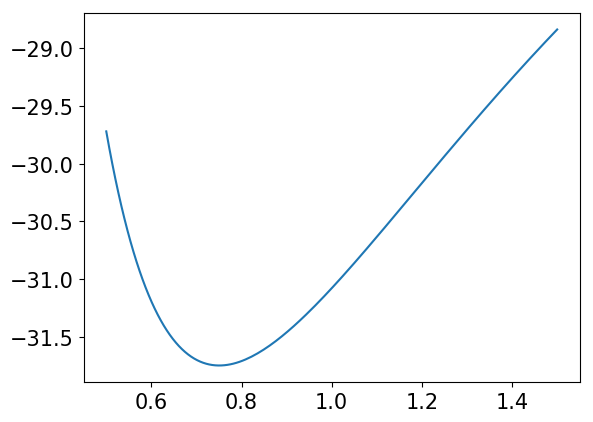

In [23]:
init = 10
plt.plot(seps, ens)
plt.show()

In [24]:
data = seps
labels = ens

train_indices = [int(n) for n in np.round(np.linspace(0, 149, m))]
test_indices = [n for n in range(150) if n not in train_indices]

# if len(train_indices) != m:
#     print("Size of training set doesn't match the m specified")

x_train = np.array([data[n] for n in train_indices])
x_test = np.array([data[n] for n in test_indices])
y_train = np.array([labels[n] for n in train_indices])
y_test = np.array([labels[n] for n in test_indices])

# convert to np arrays
x_train = np.array(x_train)
x_train = x_train.reshape(-1, 1)
x_test = np.array(x_test)
x_test = x_test.reshape(-1, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_test_list = [data[n] for n in test_indices]
x_train_list = [data[n] for n in train_indices]


In [25]:
kernel_choice = 'rbf'  # specify either c_rbf, rbf, matern or expsinesquared
m = 7  # number of training points

kernel_dict = {
    'c_rbf': C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)),
    'rbf': RBF(length_scale=10, length_scale_bounds=(1e-2, 1e2)),
    'matern': Matern(length_scale=10, length_scale_bounds=(1e-2, 1e2),
                     nu=10),
    'expsinesquared': ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                     length_scale_bounds=(1e-2, 1e2),
                                     periodicity_bounds=(1e-2, 1e2))}

kernel = kernel_dict[kernel_choice]

print("\nKernel: {}".format(kernel))
print("Hyperparameters: \n")

for hyperparameter in kernel.hyperparameters: print(hyperparameter)
print("Parameters:\n")

params = kernel.get_params()
for key in sorted(params): print("%s : %s" % (key, params[key]))
    
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, normalize_y=True)

print("\nFitting GP...")
gp.fit(x_train, y_train)

y_pred_test = gp.predict(np.atleast_2d(x_test_list).T)
y_pred_train = gp.predict(np.atleast_2d(x_train_list).T)
y_pred_all, sigma = gp.predict(np.atleast_2d(seps).T, return_std=True)


Kernel: RBF(length_scale=10)
Hyperparameters: 

Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[1.e-02, 1.e+02]]), n_elements=1, fixed=False)
Parameters:

length_scale : 10
length_scale_bounds : (0.01, 100.0)

Fitting GP...


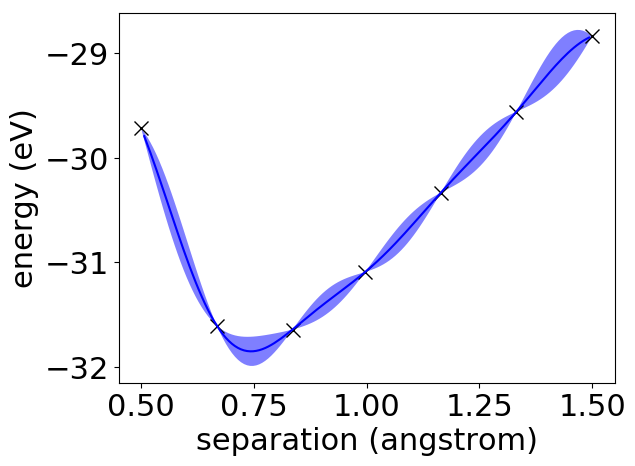

In [27]:
fig = plt.figure()
plt.plot(x_train, y_train, 'kx', markersize=10, label=u'Training Data')
plt.plot(x_test, y_pred_test, 'b-', label=u'Predictions')
plt.fill(np.concatenate([seps, seps[::-1]]),
         np.concatenate([y_pred_all - 2 * sigma,
                         (y_pred_all + 2 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.rcParams.update({'font.size': 22})
plt.xlabel('separation (angstrom)')
plt.ylabel('energy (eV)')
# plt.legend(loc='upper left')

plt.show()

fig.savefig('H2_GP.pdf', format='pdf',bbox_inches='tight')

# 2D fingerprint

In [181]:
# given a supercell and an atom number, return symmetry vectors
def symmetrize_forces(pos, atom, cutoff=0.5, eta_lower=-2, eta_upper=2, eta_length=8):

    # set atom position
    pos_atom = np.array(pos[atom])
    etas = np.logspace(eta_lower, eta_upper, eta_length)

    # initialize symmetry vectors
    symm_x = np.zeros([len(etas)])
    symm_y = np.zeros([len(etas)])

    # loop through positions
    for n in range(len(pos)):
        if n != atom:
            # position relative to reference atom
            diff_curr = np.array(pos[n]) - pos_atom
            dist = np.linalg.norm(diff_curr)
        

            # symmetrize according to Botu (2015)
            if dist < cutoff:
                cut_val = 0.5 * (np.cos(np.pi * dist / cutoff) + 1)

                vec = diff_curr

                # get symmetry vectors
                symm_x += [(vec[0] / dist) * \
                                    np.exp(-(dist / eta)**2) * cut_val for eta in etas]

                symm_y += [(vec[1] / dist) * \
                        np.exp(-(dist / eta)**2) * cut_val for eta in etas]

    return symm_x, symm_y

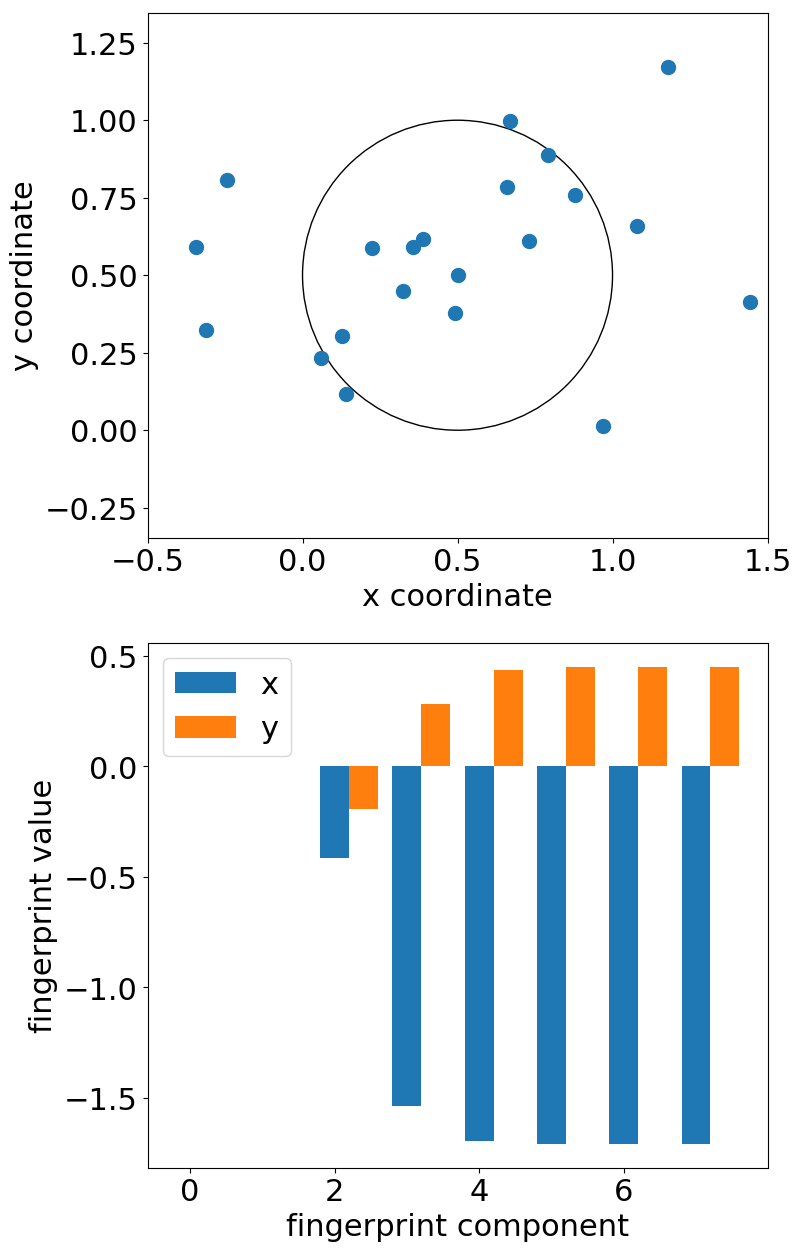

In [185]:

circle = plt.Circle((0.5, 0.5), 0.5, color='black',fill=False)


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,15)) # note we must use plt.subplots, not plt.subplot

pos_x = []
pos_y = []
pos = []
noa = 20

# append center atom
pos_x.append(0.5)
pos_y.append(0.5)
pos.append([0.5,0.5])

# append random atoms
for n in range(noa):
    rand_rad = np.random.random() * 1
    rand_ang = np.random.random() * 2 * np.pi

    x_curr = 0.5 + rand_rad * np.cos(rand_ang)
    y_curr = 0.5 + rand_rad * np.sin(rand_ang)
    
    pos_x.append(x_curr)
    pos_y.append(y_curr)
    pos.append([x_curr, y_curr])
    

ax1.add_artist(circle)
ax1.plot(pos_x, pos_y,'.',MarkerSize=20)
ax1.set_xlim(-0.5,1.5)
ax1.set_ylim(-0.5,1.5)
ax1.set_aspect('equal', adjustable='datalim')
ax1.set_xlabel('x coordinate')
ax1.set_ylabel('y coordinate')
# ax1.axis('off')

symm_x, symm_y = symmetrize_forces(pos, 0)
ax2.bar(np.arange(0,8,1),symm_x,width=0.4, label = 'x')
ax2.bar(np.arange(0,8,1)+0.4,symm_y,width=0.4, label = 'y')
ax2.set_xlabel('fingerprint component')
ax2.set_ylabel('fingerprint value')
plt.legend()
plt.show()

fig.savefig('fingprint.pdf', format='pdf',bbox_inches='tight')

# Error test

In [4]:
def parse_qe_pwscf_md_output(outfile):
#def parse_qe_pwscf_md_output(path):

    steps={}

    # Get the lines out of the file first
    with open(outfile, 'r') as outf:
        lines = outf.readlines()

    # Because every step is marked by a total energy printing with the !
    # as the first character of the line, partition the file of output
    # into all different chunks of run data

    # Get the indexes to carve up the document later
    split_indexes=[N for N in range(len(lines)) if '!'==lines[N][0]]

    # Cut out the first chunk 
    # TODO: Analyze first chunk
    first_chunk=lines[0:split_indexes[0]]

    step_chunks = []
    # Carve up into chunks
    for n in range(len(split_indexes)):
        step_chunks.append(lines[split_indexes[n]:split_indexes[n+1] if n!=len(split_indexes)-1 else len(lines)]) 



    # Iterate through chunks
    for current_chunk in step_chunks:


        # Iterate through to find the bounds of regions of interest

        # Forces
        force_start_line = [line for line in current_chunk if 'Forces acting on atoms' in line][0]
        force_end_line   = [line for line in current_chunk if 'Total force' in line][0]
        force_start_index = current_chunk.index(force_start_line)+2
        force_end_index = current_chunk.index(force_end_line)-2

        # Positions
        atoms_start_line = [line for line in current_chunk if 'ATOMIC_POSITIONS' in line][0]
        atoms_end_line   = [line for line in current_chunk if 'kinetic energy' in line][0]
        atoms_start_index = current_chunk.index(atoms_start_line)+1
        atoms_end_index = current_chunk.index(atoms_end_line)-3

        # Misc Facts
        temperature_line = [ line for line in current_chunk if 'temperature' in line][0]
        dyn_line = [line for line in current_chunk if 'Entering Dynamics' in line][0]
        dyn_index = current_chunk.index(dyn_line)
        time_index = dyn_index+1

        # Parse through said regions of interest to get the information out

        forces = []
        for line in current_chunk[force_start_index:force_end_index+1]:
            forceline= line.split('=')[-1].split()
            forces.append([float(forceline[0]),float(forceline[1]),float(forceline[2])])
        total_force = float(force_end_line.split('=')[1].strip().split()[0])
        SCF_corr    = float(force_end_line.split('=')[2].strip()[0])


        positions =[]
        elements=[]
        for line in current_chunk[atoms_start_index:atoms_end_index+1]:
            atomline = line.split()
            elements.append(atomline[0])
            positions.append([float(atomline[1]),float(atomline[2]),float(atomline[3])])

        # Get Misc info 
        toten = float(current_chunk[0].split('=')[-1].strip().split()[0])
        temperature_line = temperature_line.split('=')[-1]
        temperature = float(temperature_line.split()[0])
        iteration = int(dyn_line.split('=')[-1])
        timeline = current_chunk[time_index].split('=')[-1].strip().split()[0]
        time = float( timeline)
        Ekin = float(atoms_end_line.split('=')[1].strip().split()[0])


        # Record the data associated with this step
        steps[iteration]={'iteration':iteration,
                           'forces':forces, 
                           'positions':positions,
                           'elements':elements,
                           'temperature':temperature,
                           'time':time,
                           'energy':toten,
                           'ekin':Ekin,
                           'kinetic energy':Ekin,
                           'total energy':toten,
                           'total force':total_force,
                           'SCF correction':SCF_corr}

    return(steps)

In [5]:
outfile ='/Users/jonpvandermause/Research/GP/ML-electron-density/Si_Supercell_MD/si.md.out'
Si_MD_Parsed = parse_qe_pwscf_md_output(outfile)

In [6]:
def get_cutoff_vecs(vec, brav_mat, brav_inv, vec1, vec2, vec3, cutoff):
    # get bravais coefficients
    coeff = np.matmul(brav_inv, vec)
    
    # get bravais coefficients for atoms within one super-super-cell
    coeffs = [[],[],[]]
    for n in range(3):
        coeffs[n].append(coeff[n])
        coeffs[n].append(coeff[n]-1)
        coeffs[n].append(coeff[n]+1)
        coeffs[n].append(coeff[n]-2)
        coeffs[n].append(coeff[n]+2)

    # get vectors within cutoff
    vecs = []
    dists = []
    for m in range(len(coeffs[0])):
        for n in range(len(coeffs[1])):
            for p in range(len(coeffs[2])):
                vec_curr = coeffs[0][m]*vec1 + coeffs[1][n]*vec2 + coeffs[2][p]*vec3
                
                dist = np.linalg.norm(vec_curr)

                if dist < cutoff:
                    vecs.append(vec_curr)
                    dists.append(dist)
                    
    return vecs, dists

In [7]:
# given a supercell and an atom number, return symmetry vectors
def symmetrize_forces(pos, atom, cutoff, eta_lower, eta_upper, eta_length, brav_mat, brav_inv,\
                     vec1, vec2, vec3):

    # set atom position
    pos_atom = np.array(pos[atom])
    etas = np.logspace(eta_lower, eta_upper, eta_length)

    # initialize symmetry vectors
    symm_x = np.zeros([len(etas)])
    symm_y = np.zeros([len(etas)])
    symm_z = np.zeros([len(etas)])
    symm_r = np.zeros([len(etas)])
    
    # initialize weight factor
    Z = np.zeros([len(etas)])

    # loop through positions to find all atoms and images in the neighborhood
    for n in range(len(pos)):
        # note that images of the atom don't contribute to symmetry vectors
        if n != atom:
            # position relative to reference atom
            diff_curr = np.array(pos[n]) - pos_atom

            # get images within cutoff
            vecs, dists = get_cutoff_vecs(diff_curr, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)

            # symmetrize according to Botu (2015)
            for vec, dist in zip(vecs, dists):
                # get cutoff factor
                cut_val = 0.5 * (np.cos(np.pi * dist / cutoff) + 1)
#                 cut_val = 1
                
                # get raw symmetry vectors
                symm_x += [(vec[0] / dist) * \
                        np.exp(-(dist / eta)**2) * cut_val for eta in etas]

                symm_y += [(vec[1] / dist) * \
                        np.exp(-(dist / eta)**2) * cut_val for eta in etas]

                symm_z += [(vec[2] / dist) * \
                        np.exp(-(dist / eta)**2) * cut_val for eta in etas]
                
                symm_r += [np.exp(-(dist / eta)**2) * cut_val for eta in etas]
                
                # update weights
                Z += [np.exp(-(dist / eta)**2) for eta in etas]
    
    # normalize the symmetry vectors
#     symm_x = symm_x / Z
#     symm_y = symm_y / Z
#     symm_z = symm_z / Z
#     symm_r = symm_r / Z
    
    # concatenate the symmetry vectors to represent the full environment
    symm_x_cat = np.concatenate((symm_x, symm_y, symm_z))
    symm_y_cat = np.concatenate((symm_y, symm_z, symm_x))
    symm_z_cat = np.concatenate((symm_z, symm_x, symm_y))
                
    return symm_x_cat, symm_y_cat, symm_z_cat

In [8]:
# for a given supercell, calculate symmetry vectors for each atom
def augment_database(pos, forces, database, cutoff, eta_lower, eta_upper, eta_length, \
                            brav_mat, brav_inv, vec1, vec2, vec3):
    for n in range(len(pos)):
        # get symmetry vectors
        symm_x, symm_y, symm_z = symmetrize_forces(pos, n, cutoff, eta_lower, eta_upper, \
                                                   eta_length, brav_mat, brav_inv, vec1, vec2, vec3)
        
        # append symmetry vectors
        database['symms'].append(symm_x)
        database['symms'].append(symm_y)
        database['symms'].append(symm_z)
        
        # append force components
        database['forces'].append(forces[n][0])
        database['forces'].append(forces[n][1])
        database['forces'].append(forces[n][2])

In [9]:
# normalize the symmetry vectors in the training set
def normalize_symm(td):
    symm_len = len(td['symms'][0])
    td_size = len(td['symms'])

    # initialize normalized symmetry vector
    td['symm_norm'] = copy.deepcopy(td['symms'])
    
    # store normalization factors
    td['symm_facs'] = []

    for m in range(symm_len):  
        # calculate standard deviation of current symmetry element
        vec = np.array([td['symms'][n][m] for n in range(td_size)])
        vec_std = np.std(vec)
        
        # store standard deviation
        td['symm_facs'].append(vec_std)

        # normalize the current element
        for n in range(td_size):
            td['symm_norm'][n][m] = td['symm_norm'][n][m] / vec_std

In [10]:
# normalize forces
def normalize_force(td):
    td_size = len(td['forces'])

    # initialize normalized force vector
    td['forces_norm'] = copy.deepcopy(td['forces'])

    # calculate standard deviation of force components
    vec_std = np.std(td['forces'])

    # store standard deviation
    td['force_fac'] = vec_std

    # normalize the forces
    for n in range(td_size):
        td['forces_norm'][n] = td['forces_norm'][n] / vec_std

In [11]:
# augment and normalize
def aug_and_norm(pos, forces, database, cutoff, eta_lower, eta_upper, eta_length, \
                            brav_mat, brav_inv, vec1, vec2, vec3):
    # augment
    augment_database(pos, forces, database, cutoff, eta_lower, eta_upper, eta_length, \
                            brav_mat, brav_inv, vec1, vec2, vec3)
    
    # normalize forces
    normalize_force(database)
    normalize_symm(database)

In [12]:
# return closest points in database
def find_closest_pts(symm, db, nop):   
    # assemble list of distances from database points
    db_dists = []
    db_size = len(db['symms'])
    for n in range(db_size):
        db_symm = db['symms'][n]
        db_dist = np.linalg.norm(db_symm - symm)
        db_dists.append(db_dist)
    
    # sort distances
    db_pts = list(range(db_size))
    db_dists, db_pts = (list(m) for m in zip(*sorted(zip(db_dists, db_pts))))
    
    top = min(nop, len(db['symms']))
    
    return db_pts[0:top]    

In [13]:
# train GP model on the current database
def train_gp(db, length_scale, length_scale_min, length_scale_max):
    # set kernel
    kernel = RBF(length_scale=length_scale, length_scale_bounds=(length_scale_min, length_scale_max))

    # make GP
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
    
    # fit GP model
#     x_train = db['symms']
    x_train = db['symm_norm']
    y_train = db['forces_norm']
    gp.fit(x_train, y_train)
    
    return gp

In [14]:
# predict force with the current gp model
def gp_pred(symm, norm_fac, gp):
    # predict with model
    pred = gp.predict(symm.reshape(1,-1), return_std = True)
    force_pred = pred[0][0] * norm_fac
    std_pred = pred[1][0] * norm_fac
    
    return force_pred, std_pred

In [15]:
# set MD parameters
frames = 30
noa = 54

# get bravais matrix inverse for 3x3x3 supercell of Silicon
alat = 5.431
brav_mat = np.array([[0.0, alat/2, alat/2], [alat/2, 0.0, alat/2], [alat/2, alat/2, 0.0]])*3
brav_inv = np.linalg.inv(brav_mat)

# set GP parameters
length_scale = 1
length_scale_min = 1e-5
length_scale_max = 1e5

# set threshold parameters
force_conv = 25.71104309541616 # Ry/au to eV/A
err_thresh = 0.05

# get bravais vectors
vec1 = brav_mat[:,0]
vec2 = brav_mat[:,1]
vec3 = brav_mat[:,2]

# choose symmetry parameters
eta_lower = 0
eta_upper = 2
eta_length = 10
cutoff = 8 # in angstrom

In [16]:
# initialize the database
db = {'symms':[], 'forces':[]}

all_errs = []
all_err_preds = []

# loop through MD snapshots
for n in range(frames):
    
    print('frame no '+str(n))
    
    # choose starting point
    init = 500
    
    # get positions and forces
    pos = Si_MD_Parsed[init+n]['positions'] # compute using Verlet algorithm in actual implementation
    forces = Si_MD_Parsed[init+n]['forces'] # unknown in actual implementation (either estimated or computed with DFT)
    
    # if first snapshot, add to database
    if n == 0:
        # augment and normalize the database
        aug_and_norm(pos, forces, db, cutoff, eta_lower, eta_upper, eta_length, \
                            brav_mat, brav_inv, vec1, vec2, vec3)
        
        # train initial GP model
        gp = train_gp(db, length_scale, length_scale_min, length_scale_max)
        
    else:
        # record errors 
        errs = []
        err_preds = []
        tot_force = []
        thresh_count = 0
        
        # make GP force predictions for each atom (this can be easily parallelized)
        thresh = 0
        for m in range(noa):
            # symmetrize atomic environment
            atom = m
            symm = symmetrize_forces(pos, atom, cutoff, eta_lower, eta_upper, eta_length, brav_mat, brav_inv,\
                     vec1, vec2, vec3)
            
            # loop over three symmetry vectors
            for p in range(3):
                symm_comp = symm[p]
                symm_norm = np.array([symm_comp[q] / db['symm_facs'][q] for q in range(len(symm_comp))])
                
                # estimate the force component and model error
                norm_fac = db['force_fac']
                force_pred, std_pred = gp_pred(symm_norm, norm_fac, gp)
                
                # calculate error
                err_pred = std_pred * force_conv
                true_force = forces[m][p] * force_conv
                true_error = np.abs(forces[m][p] - force_pred) * force_conv
                perc_err = np.abs(true_error) / np.abs(true_force)
                
                all_errs.append(true_error)
                all_err_preds.append(err_pred)
                     
                errs.append(true_error)
                err_preds.append(err_pred)
                tot_force.append(np.abs(true_force))
                
                # if the error is above the threshold, add the point to the database
                if true_error > err_thresh:                   
                    # augment the database and signal to retrain
                    db['symms'].append(symm_comp)
                    db['forces'].append(forces[m][p])
                    thresh_count += 1
                    thresh = 1
            
        # if error is above threshold, normalize and retrain
        if thresh == 1:
            normalize_force(db)
            normalize_symm(db)
            print('retraining. database size is '+str(len(db['symms'])))
            print('added '+str(thresh_count))
            print('average error is '+str(np.mean(np.array(errs))))
            print('average predicted error is '+str(np.mean(np.array(err_preds))))
            print('average of all errors is '+str(np.mean(np.array(all_errs))))
            print('average force is '+str(np.mean(np.array(tot_force))))
            gp = train_gp(db, length_scale, length_scale_min, length_scale_max)
        
        if thresh == 0:
            print('all GP estimates below threshold. database size is '+str(len(db['symms'])))
            print('average error is '+str(np.mean(np.array(errs))))
            print('average force is '+str(np.mean(np.array(tot_force))))
        
        

frame no 0
frame no 1
retraining. database size is 170
added 8
average error is 0.01727054904389572
average predicted error is 0.033707569812993346
average of all errors is 0.01727054904389572
average force is 0.27558046663421
frame no 2
retraining. database size is 198
added 28
average error is 0.029452794790292915
average predicted error is 0.060904109661264146
average of all errors is 0.02336167191709432
average force is 0.27884904012336614
frame no 3
retraining. database size is 228
added 30
average error is 0.02772510446343923
average predicted error is 0.06503016697834905
average of all errors is 0.024816149432542622
average force is 0.2817928577446042
frame no 4
retraining. database size is 253
added 25
average error is 0.024513679734820305
average predicted error is 0.06156508318158297
average of all errors is 0.024740532008112045
average force is 0.28621576660396325
frame no 5
retraining. database size is 278
added 25
average error is 0.02626772234562044
average predicted erro

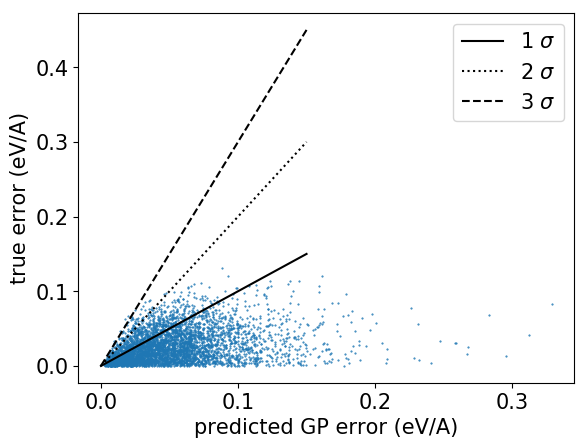

In [26]:
x_lin = 0.15
ms = 1

fig = plt.figure()
plt.plot(all_err_preds, all_errs, '.',MarkerSize = ms, )
plt.plot(np.linspace(0,x_lin,100),np.linspace(0,1*x_lin,100),'k', label='1 $\sigma$')
plt.plot(np.linspace(0,x_lin,100),np.linspace(0,2*x_lin,100),'k:',label='2 $\sigma$')
plt.plot(np.linspace(0,x_lin,100),np.linspace(0,3*x_lin,100),'k--',label='3 $\sigma$')
plt.xlabel('predicted GP error (eV/A)')
plt.ylabel('true error (eV/A)')
plt.legend()
plt.show()

fig.savefig('error.pdf', format='pdf',bbox_inches='tight')

# Adaptive scheme

In [63]:
outfile = '/Users/jonpvandermause/Research/GP/Production/update_12.txt'

pred_errs = []
# Get the lines out of the file first
with open(outfile, 'r') as outf:
    lines = outf.readlines()
    
for line in lines:
    if 'average predicted' in line:
        pred_err = float(line.split()[4][:-5])
        
        pred_errs.append(pred_err)

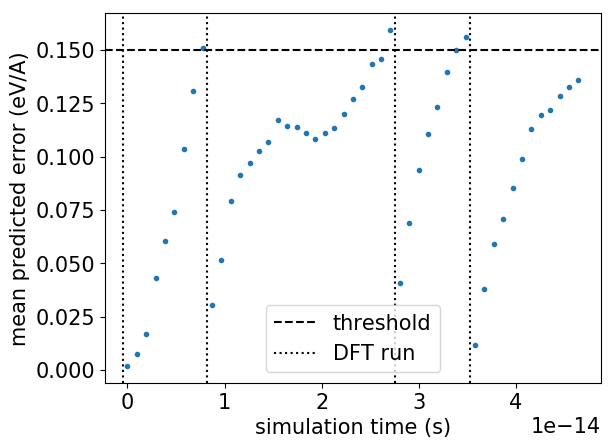

In [92]:
tstep = 20 * 4.83776865301828e-17
times = [tstep * n for n in range(49)]

fig = plt.figure()
plt.plot(times, pred_errs, '.')
plt.axhline(0.15, ls = '--',color='black',label='threshold')
plt.axvline(tstep * -0.5, ls = ':',color='black')
plt.axvline(tstep * 8.5, ls = ':',color='black')
plt.axvline(tstep * 28.5, ls = ':',color='black')
plt.axvline(tstep * 36.5, ls = ':',color='black',label='DFT run')
plt.xlabel('simulation time (s)')
plt.ylabel('mean predicted error (eV/A)')
plt.legend()
plt.show()

fig.savefig('adapt.pdf', format='pdf',bbox_inches='tight')